In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '18'
plt.rcParams['figure.dpi'] = 125
plt.rcParams['figure.facecolor'] = 'white'

import numpy as np
import xarray as xr
import pandas as pd
import nctoolkit as nc
import datetime

# ds = nc.open_thredds('http://tds.maracoos.org/thredds/dodsC/AVHRR/2021/1Agg')
# ds = nc.open_thredds('http://basin.ceoe.udel.edu/thredds/dodsC/avhrr_unfiltered_sst.nc')

nctoolkit is using Climate Data Operators version 2.2.0


In [21]:
ds1 = nc.open_thredds('http://tds.maracoos.org/thredds/dodsC/AVHRR/2019/1Agg')

ds2 = nc.open_thredds('http://basin.ceoe.udel.edu/thredds/dodsC/avhrr_unfiltered_sst.nc')

In [24]:
dsx1 = ds1.to_xarray()
dsx1 = dsx1.sortby('time')

dsx2 = ds2.to_xarray()
dsx2 = dsx2.sortby('time')

In [6]:
date = '2019-01-10T15:00'
t = np.datetime64(date)

In [7]:
t 

numpy.datetime64('2019-01-10T15:00')

In [8]:
dsx.time.values[0]



numpy.datetime64('2019-01-01T00:57:00.000000000')

In [9]:
dt = t-dsx.time.values

In [10]:
dt

array([   828180000000000,    798120000000000,    792060000000000, ...,
       -30675600000000000, -30691860000000000, -30697740000000000],
      dtype='timedelta64[ns]')

In [11]:
date = '2019-07-01T10:00'
t = np.datetime64(date)
dsx1 = dsx.sel(time=t, method='nearest')

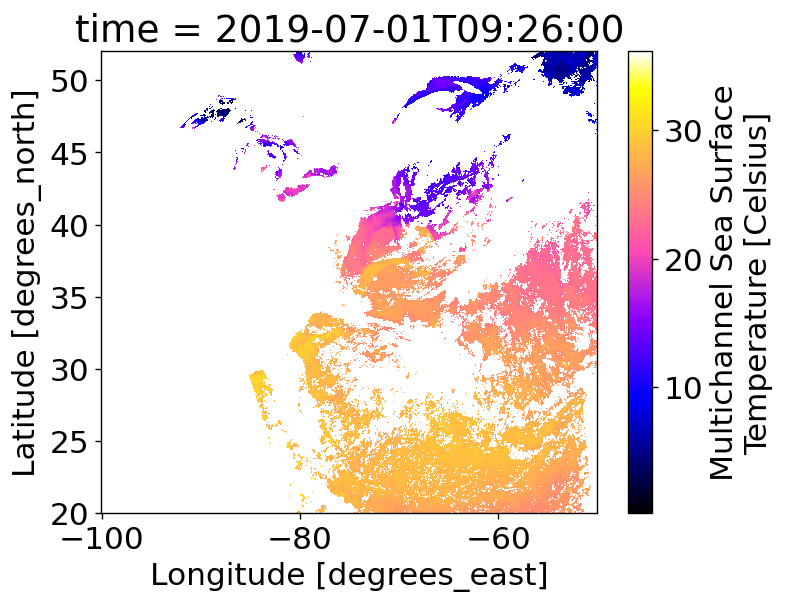

In [12]:
dsx1.mcsst.plot(cmap='gnuplot2', clim=(5,35))

In [19]:
day_ang = dsx.sel(time=slice('2019-07-01', '2019-07-01'))

In [16]:
day_ang = dsx.sel(time=slice('2019-07-01', '2019-07-01')).groupby('time.day').mean('time')

In [17]:
day_ang

<xarray.Dataset>
Dimensions:  (lon: 4500, lat: 3661, day: 1)
Coordinates:
  * lon      (lon) float64 -100.0 -99.99 -99.98 -99.97 ... -50.02 -50.01 -50.0
  * lat      (lat) float64 20.0 20.01 20.02 20.03 ... 51.98 51.99 51.99 52.0
  * day      (day) int64 1
Data variables:
    mcsst    (day, lat, lon) float32 nan nan nan nan nan ... 8.2 8.3 8.25 8.2
Attributes: (12/22)
    url:                       http://www.ceoe.udel.edu, http://marine.rutger...
    groundstation:             RU-COOL L-band receiver at Rutgers University,...
    creator_name:              Matt Oliver
    creator_email:             moliver@udel.edu
    institution:               University of Delaware
    source:                    NOAA AVHRR
    ...                        ...
    publisher_url:             http://maracoos.org
    Conventions:               ACDD-1.3, CF-1.6
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    NCO:                       4.0.8
    composite_members:          20191231.2031 20191231.2031 20191231.2031 201...
    license:                   Freely Distributed

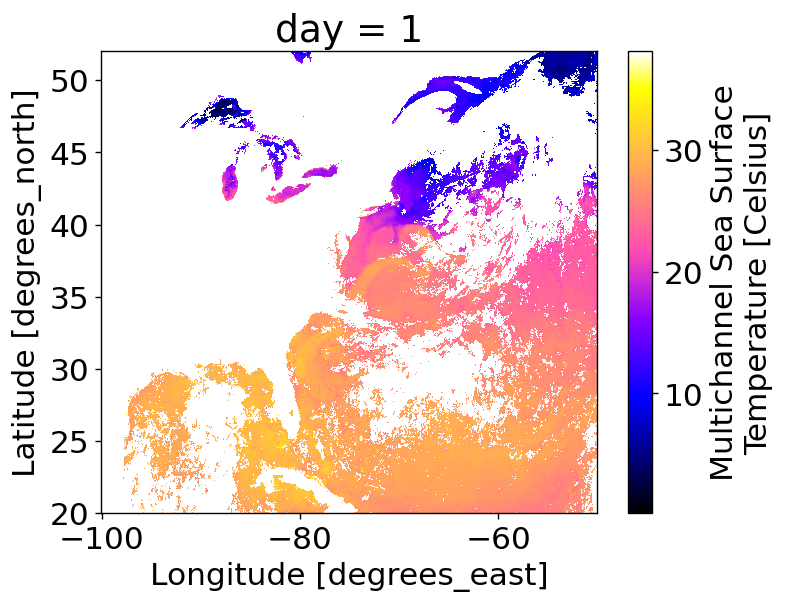

In [18]:
day_ang.mcsst.plot(cmap='gnuplot2', clim=(5,35))

In [ ]:
abstime = np.abs(dsx.time-t)
abstime = np.timedelta64(abstime.time.values[0], 'h')
t_loc = np.where(abstime<=1)

# # Now I can use that index location to get the values at the x/y diminsion
# point_ds = ds.sel(x=xloc, y=yloc)

In [ ]:
abstime.time.values[0]

In [ ]:
a = xr_ds.isel(time=1500)

In [ ]:
a.mcsst.plot()

In [ ]:
d = a.mcsst.values.copy()
lat = a.lat.values.copy()
lon = a.lon.values.copy()
plt.figure(figsize=(15,10))
plt.pcolormesh(lon, lat,d, cmap='gnuplot2')
plt.clim(5,35)
plt.colorbar(label='Temp [c]')
plt.show()

In [ ]:
d = a.mcsst.values.copy()

In [ ]:
a.lat